In [1]:

import os
from torch.utils.data import DataLoader

from core.dataset import dataset_from_scratch, dataset_from_hdf5
import core.config as conf

import utils.utils as utils
# from core.dataset import read_audio_file

import numpy as np
import shutil

c:\Users\umari\anaconda3\envs\DL38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
csv_file_path = os.path.join(conf.input['project_path'], 'data', 'train.csv')
csv_file_path

'c:\\Users\\umari\\projects\\AV-spatial-coherence\\data\\train.csv'

### make the relevant folders for audio and video with rig and camera information

In [3]:
# for audio

def MakeFolders(sequence_path, video=False):

    import shutil

    if not video:
        dir_1 = np.array(['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16'])
        dir_2 = np.array(['23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38'])
    else:
        dir_1 = np.array(['01','02','03','04','05','06','07','08','09','10','11'])
        dir_2 = np.array(['12','13','14','15','16','17','18','19','20','21','22'])

    all_takes = os.listdir(sequence_path)
    all_takes.pop(all_takes.index('README.txt'))

    for folder in all_takes:

        seq_dir = os.path.join(sequence_path, folder)

        # make the dirs for each rig
        os.mkdir(os.path.join(seq_dir, '01'))
        os.mkdir(os.path.join(seq_dir, '02'))
        os.mkdir(os.path.join(seq_dir, 'other'))

        for file_name in os.listdir(seq_dir):

            (end_token, idx_range) = ('.wav', range(0,2)) if not video else ('.mp4', range(-6,-4))

            if not file_name.endswith(end_token):
                pass
            else:
                if file_name[idx_range] in dir_1:
                    fol_name = '01'
                elif file_name[idx_range] in dir_2: 
                    fol_name = '02'
                else:
                    fol_name = 'other'

                file_path = os.path.join(seq_dir, file_name)
                shutil.move(file_path, os.path.join(seq_dir, fol_name, file_name))

    return

        
    # os.mkdir(os.path.join(seq_dir, 'other'))

### save video frames to folder from .mp4 file

In [4]:
import cv2

def SaveVideoFrames(data_path):

    vid_data_path = os.path.join(data_path, 'videos')
    frame_data_path = os.path.join(data_path, 'frames')

    rig_folders = ['01', '02']

    dir_1 = np.array(['01','02','03','04','05','06','07','08','09','10','11'])
    dir_2 = np.array(['12','13','14','15','16','17','18','19','20','21','22'])

    for sequence_name in os.listdir(vid_data_path):
        if not sequence_name=="README.txt":
            if sequence_name not in os.listdir(frame_data_path):
                os.mkdir(os.path.join(frame_data_path, sequence_name))
                
            for rig in rig_folders:
                
                if rig not in os.listdir(os.path.join(frame_data_path, sequence_name)):
                    os.mkdir(os.path.join(frame_data_path, sequence_name, rig))

                vid_path = os.path.join(vid_data_path, sequence_name, rig)
                    
                for cam_idx in range(11):
                
                    if rig == '01':
                        cam = dir_1[cam_idx]
                        if 'cam-'+cam not in os.listdir(os.path.join(frame_data_path, sequence_name, rig)):
                            print(os.listdir(os.path.join(frame_data_path, sequence_name, rig)))
                            os.mkdir(os.path.join(frame_data_path, sequence_name, rig, 'cam-'+cam))
                        cam_save = cam

                    elif rig == '02':
                        cam = dir_2[cam_idx]
                        if 'cam-'+cam not in os.listdir(os.path.join(frame_data_path, sequence_name, rig)):
                            os.mkdir(os.path.join(frame_data_path, sequence_name, rig, 'cam-'+cam))
                        cam_save = cam


                    frame_path = os.path.join(frame_data_path, sequence_name, rig, 'cam-'+cam_save)
                    vid_name = sequence_name + '-cam' + cam + '.mp4'

                    vid_path_cam = os.path.join(vid_path, vid_name)
                    
                    if len(os.listdir(frame_path)) == 0:
                        print("copying and saving frames for sequence: {} rig: {} cam: {}  ".format(sequence, rig, cam))
                        vidcap = cv2.VideoCapture(vid_path_cam)
                        success,image = vidcap.read()
                        count = 0

                        # print(image.shape)

                        while success:
                            image = cv2.resize(image, (612,512))
                            cv2.imwrite(os.path.join(frame_path, vid_name[:-4] + "-frame"+str(count)+".jpg"), image)     # save frame as JPEG file      
                            success,image = vidcap.read()
                            # print('Read a new frame: ', success)
                            count += 1

                        vidcap.release()

                    else:
                        print("already saved frames for sequence: {} rig: {} cam: {}  ".format(sequence, rig, cam))


    return
            

### upload the image frames to batch and augment

In [1]:
from PIL import Image
import torch
import matplotlib.pyplot as plt

import torchvision.transforms as transforms

import core.config as conf
import numpy as np

def read_video_file(sequence, train_or_test, rig, cam_vid, initial_time, base_path):

    cam_vid = cam_vid.zfill(2)

    data_path = os.path.join(base_path, 'data', 'RJDataset')
    frame_data_path = os.path.join(data_path, 'frames')

    frame_path = os.path.join(frame_data_path, sequence, rig, 'cam-'+cam_vid)

    fps = conf.input['fps']

    period = conf.input['frame_len_sec']
    end_time = initial_time + period
    num_frames = conf.training_param['frame_vid_samples']

    frame_idxs = np.linspace(round(initial_time*fps), round(end_time*fps), num_frames)

    imgs = []
    for idx in frame_idxs:
        frame_name = os.path.join(frame_path, sequence +'-cam'+ cam_vid + '-frame' + str(int(idx)) + '.jpg')
        im = Image.open(frame_name)

        im = transforms.Resize((224, 224))(im)

        # augmenting the images
        if train_or_test == 'train':
            im = transforms.ColorJitter((0.6, 1.4), (0.6, 1.4), (0.6, 1.4), (-0.1, 0.1))(im)
            im = transforms.RandomGrayscale(0.2)(im)

        im = transforms.ToTensor()(im)

        imgs.append(im)

    return imgs


c:\Users\umari\anaconda3\envs\DL38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path = os.getcwd()

rig = '01'
cam_vid = '01'
sequence = 'conversation1_t1'
train_or_test = 'train'

initial_time = 4.4

imgs = read_video_file(sequence, train_or_test, rig, cam_vid, initial_time, base_path)

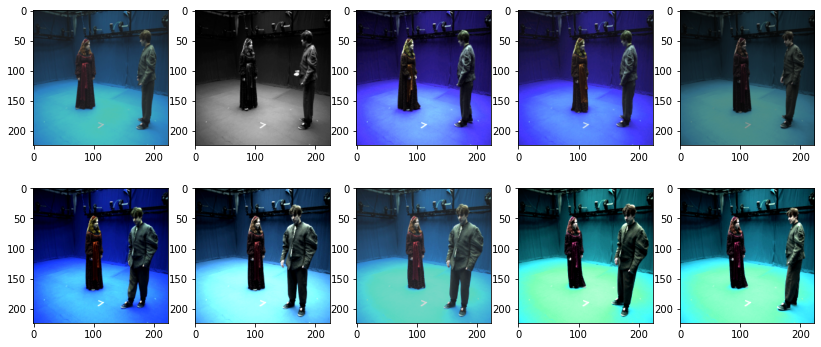

In [3]:
plt.figure(figsize=(14,6))

for i, img in enumerate(imgs):
    plt.subplot(2,5,i+1)
    plt.imshow(img.permute(1,2,0))

    pass
plt.show()

In [1]:
import torch
import torch.nn as nn

from AVOL import SubNet_main, SubNet_aud, SubNet_vid, MergeNet

aud_net = SubNet_main(mode='audio')
vid_net = SubNet_main(mode='video')

aud_sub = SubNet_aud()
vid_sub = SubNet_vid()

net = MergeNet()

c:\Users\umari\anaconda3\envs\DL38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from core.dataset import dataset_from_scratch
import core.config as conf
from torch.utils.data import Subset, DataLoader
import torch

current_dir = os.getcwd()
csv_file_path = os.path.join(conf.input['project_path'], 'data', 'train.csv')

d_dataset = dataset_from_scratch(csv_file_path, train_or_test='train', normalize=False, augment=False)

d_subset = Subset(d_dataset, list(range(4)))
d_sub = DataLoader(d_subset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)


### cycling shifting for negative samples

4


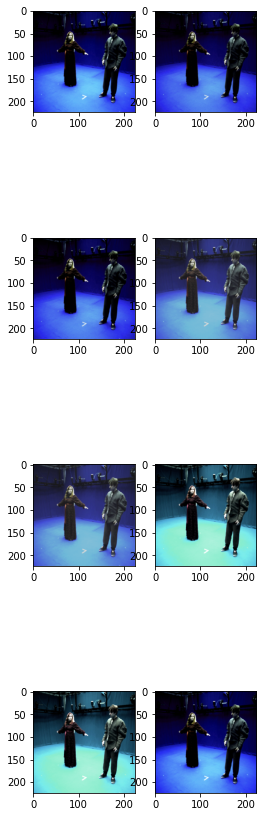

In [13]:
import matplotlib.pyplot as plt

for data in d_sub:
    print(len(data))
    BS = len(data)
    all_frames = data[-1]

    imgs_pos = all_frames[torch.randint(len(all_frames), (1,1))]
    audio = data[0]

    imgs_neg = torch.roll(imgs_pos, int(torch.randint(low=1, high=BS, size=(1,1))), dims=0)

    plt.figure(figsize=(4, 16))
    count=1
    for i in range(BS):
        img1 = imgs_pos[i]
        img2 = imgs_neg[i]

        plt.subplot(BS,2,count)
        plt.imshow(img1.permute(1,2,0))
        plt.subplot(BS,2,count+1)
        plt.imshow(img2.permute(1,2,0))

        count +=2

    plt.show()


(4, 10, 16, torch.Size([16, 960, 64]), torch.Size([3, 224, 224]))

In [3]:
img = torch.rand((8,3,224,224))
aud = torch.rand((8,16,960,64))
cam_ID = torch.rand((8,11))

# img1, aud1 = vid_net(img), aud_net(aud)

# print(img1.shape, aud1.shape)

# img2, aud2 = vid_sub(img1), aud_sub(aud1, cam_ID)

# print(img2.shape, aud2.shape)

x, x_class = net(img, aud)


BS = img.shape[0]

imgs_pos = img

# create contrastive batch (shift by some n)
imgs_neg = torch.roll(imgs_pos, torch.randint(1, BS), dim=0)

# TODO: CAM ID

out_pos = net(imgs, aud)
out_neg = net(imgs_neg, aud)

torch.Size([1, 128, 14, 14]) torch.Size([1, 128, 1, 1])
torch.Size([1, 14, 14]) torch.Size([1])


In [8]:
cam_ID.shape

torch.Size([1, 11])

In [10]:
a = torch.rand((1,128))
b = torch.rand((1,11))

c = torch.concat((a,b), dim=-1)

c.shape

torch.Size([1, 139])